In [1]:
import ast
import concurrent.futures
import math
import warnings
from concurrent.futures import ThreadPoolExecutor
from datetime import timedelta

import numpy as np
import pandas as pd
import yfinance as yf
from matplotlib import pyplot as plt
from pandas.core.indexes.datetimes import date
from tqdm import tqdm

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

We can get the **full** symbol universe from this Git repo: https://github.com/mlapenna7/yh_symbol_universe

The version as of January 2023 is in this repository already as `yhallsym.txt`

In [ ]:
# Reading the json as a dict
with open('yhallsym.txt', 'r') as file:
  all_tickers = file.read().rstrip()

all_tickers_dict = ast.literal_eval(data)

But generally speaking, we should ignore the above and focus on just the S&P500 since it's an easier calculation and represents safer investments.

In [18]:
# Set the date range we're interesed in for the rest of the analysis.
start_dt = pd.to_datetime('2000-01-01')
end_dt = pd.to_datetime('2023-02-01')

In [3]:
# This is a list of all tickers on the S&P500 circa... whenever.
spx_tickers_df = pd.read_csv('https://raw.githubusercontent.com/datasets/s-and-p-500-companies/master/data/constituents.csv', on_bad_lines='warn')

The list 'target-equities.csv' originated with a simple stock screen via ThinkorSwim to look for equities that were exposed to the Building Materials sector.

In [4]:
target_tickers_df = pd.read_csv('target-equities.csv')

The mortgage rate data comes from the weekly rate information published alongside the MBA Purchase Index and retrieved from Bloomberg.

In [5]:
mortgage_rates_df = pd.read_csv('mortgage-rates.csv')
mortgage_rates_df['Date'] = pd.to_datetime(mortgage_rates_df['Unnamed: 0'])
mortgage_rates_df = pd.DataFrame(mortgage_rates_df.set_index('Date', drop=True)['MortgageRates'])
mortgage_rates_df = mortgage_rates_df[mortgage_rates_df.index >= start_dt]

The list of Fed Funds rate changes in 'fed-actions.csv' was drawn from: https://en.wikipedia.org/wiki/History_of_Federal_Open_Market_Committee_actions

In [6]:
# Load The Fed actions data, set the dates as the index and narrow it to the timeframe we're interested in.
fed_actions_df = pd.read_csv('fed-actions.csv')
fed_actions_df['fed-date'] = pd.to_datetime(fed_actions_df['fed-date'])
fed_actions_df = fed_actions_df.set_index('fed-date', drop=True)
fed_actions_df = fed_actions_df[(fed_actions_df.index >= start_dt) & (fed_actions_df.index < end_dt)]

In [7]:
# Define your targets as the full S&P500 plus any additional you've identified.
target_tickers_lst = spx_tickers_df['Symbol'].to_list() + target_tickers_df['Symbol'].to_list() + ['^GSPC']
target_tickers_lst = list(set(target_tickers_lst))

In [ ]:
# OR Define your targets as only those potential equities you've identified.
# target_tickers_lst = list(set(target_tickers_df['Symbol'].to_list() + ['^GSPC']))

In [19]:
# Download the MONTHLY data on stock prices for our selected equities from Y Finance
targets_df = pd.DataFrame()
targets_df = yf.download(tickers=target_tickers_lst, start=start_dt, end=end_dt, interval='1mo')

# Narrow the data downloaded to only the close prices.
def format_columns_in(df):
    df = df[[(col[0], col[1]) for col in list(df) if col[0] == 'Close']]
    df.columns = [col[1] for col in list(df)]

    return df

targets_df = format_columns_in(targets_df)

[*********************100%***********************]  685 of 685 completed

6 Failed downloads:
- KHC: Exception('Lost data during merge despite all attempts to align data (see above)')
- LEN/B: No timezone found, symbol may be delisted
- XYIGY: Exception('Lost data during merge despite all attempts to align data (see above)')
- ANCHY: No timezone found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted
- BRK.B: No timezone found, symbol may be delisted


In [ ]:
# Download the stock prices for our selected equities for dates aronud Fed fund actions.
# To do this we're going to define a function to get the set of prices for each Fed action date and run the queries concurrently.
# Even with a concurrent run this will take a while
def get_prices_async(action_dt):
  range_start_dt = action_dt - timedelta(days=7)
  range_end_dt = action_dt + timedelta(days=7)
  
  df = yf.download(tickers=target_tickers_lst, start=range_start_dt, end=range_end_dt, interval='1d', threads=True)
  
  return df

In [ ]:
futures_lst = []
with ThreadPoolExecutor(max_workers=6) as executor:
  for _dt in fed_actions_df.index[:2]:
    future = executor.submit(get_prices_async, _dt)
    futures_lst.append(future)

for future in concurrent.futures.as_completed(futures_lst):
  result_df = format_columns_in(future.result())
  result_df.to_csv('fed-reactions1.csv', mode='a', index=True, header=True)

In [20]:
# This function calculates the cumulative growth rate for each equity relative to the S&P500
def calc_growth(df: pd.DataFrame) -> pd.DataFrame:
  growth_df = pd.DataFrame(index=df.index)

  for ticker in tqdm((['^GSPC'] + list(df)[:-1])):
    start_flt = None
    growth_flt = None
    ticker_indx = df[df[ticker].notnull()].index
    if len(ticker_indx) > 0:
      start_flt = df.loc[ticker_indx[0], ticker]

      for month in ticker_indx:
        if ticker == '^GSPC':
          growth_flt = (df.loc[month, ticker] / start_flt) - 1
          growth_df.loc[month, ticker] = growth_flt
        else:
          growth_flt = ((df.loc[month, ticker] / start_flt) - 1) - growth_df.loc[month, '^GSPC']
          growth_df.loc[month, ticker] = growth_flt

  return growth_df

In [23]:
growth_df = calc_growth(targets_df)

100%|██████████| 685/685 [00:45<00:00, 14.91it/s]


In [11]:
# This loop adds the growth rate in mortgage rates to their dataframe.
for month in mortgage_rates_df.index:
  growth_flt = (mortgage_rates_df.loc[month, 'MortgageRates'] / mortgage_rates_df.loc[start_dt, 'MortgageRates']) - 1
  mortgage_rates_df.loc[month, 'Growth'] = growth_flt

In [24]:
# This loop finds only those equities wih a history that goes back at least through our start date and calculates the 
# correlation between its growth relative to the S&P500 and the change in mortgage rates.
corr_df = pd.DataFrame(index=list(growth_df), columns=['mortgage-rate-corr'])
for ticker in tqdm(list(growth_df)):
  corr_flt = None
  ticker_df = pd.DataFrame(growth_df[growth_df[ticker].notnull()][ticker])
  if ticker_df.index[0] <= start_dt:
    start_dt = ticker_df.index[0]
    x_growth_arr = np.array(ticker_df[ticker])

    y_growth_arr = np.array(mortgage_rates_df[mortgage_rates_df.index >= start_dt]['Growth'])

    corr_flt = np.corrcoef(x_growth_arr, y_growth_arr)[0][1]

    corr_df.loc[ticker, 'mortgage-rate-corr'] = corr_flt

100%|██████████| 679/679 [00:04<00:00, 164.69it/s]


In [25]:
# Narrow the correlation dataframe to only the best candidates for graphing
graph_df = corr_df.sort_values('mortgage-rate-corr')[:15]

In [29]:
# Get additional company data on the most likely candidates
for tkr in tqdm(graph_df.index):
  try:
    tkr_info = yf.Ticker(tkr)
    graph_df.loc[tkr, 'name'] = tkr_info.info.get('longName')
    graph_df.loc[tkr, 'sector'] = tkr_info.info.get('sector')
    graph_df.loc[tkr, 'ebitda-margins'] = tkr_info.info.get('ebitdaMargins')
    graph_df.loc[tkr, 'long-summary'] = tkr_info.info.get('longBusinessSummary')
  except:
    print("No longer listed")


  7%|▋         | 1/15 [00:05<01:19,  5.66s/it]

No longer listed


 13%|█▎        | 2/15 [00:10<01:09,  5.31s/it]

No longer listed


 20%|██        | 3/15 [00:15<01:02,  5.21s/it]

No longer listed


 27%|██▋       | 4/15 [00:21<00:57,  5.25s/it]

No longer listed


 33%|███▎      | 5/15 [00:26<00:51,  5.15s/it]

No longer listed


 40%|████      | 6/15 [00:31<00:47,  5.24s/it]

No longer listed


 47%|████▋     | 7/15 [00:36<00:40,  5.09s/it]

No longer listed


 53%|█████▎    | 8/15 [00:41<00:35,  5.05s/it]

No longer listed


 60%|██████    | 9/15 [00:45<00:29,  4.93s/it]

No longer listed


 67%|██████▋   | 10/15 [00:53<00:28,  5.61s/it]

No longer listed


 73%|███████▎  | 11/15 [00:57<00:21,  5.38s/it]

No longer listed


 80%|████████  | 12/15 [01:02<00:15,  5.22s/it]

No longer listed


 87%|████████▋ | 13/15 [01:07<00:10,  5.16s/it]

No longer listed


 93%|█████████▎| 14/15 [01:12<00:05,  5.05s/it]

No longer listed


100%|██████████| 15/15 [01:17<00:00,  5.19s/it]

No longer listed


In [26]:
# Create a function to quickly graph the values on a two y-axis line plot
def graph_series(tkr, x_srs, y1_srs, y2_srs):
  # create figure and axis objects with subplots()
  fig, ax = plt.subplots()
  
  # Plot the first y series
  ax.plot(x_srs, y1_srs, color='red')
  ax.set_xlabel("Date", fontsize = 14)
  ax.set_ylabel(corr_df.loc[tkr].name, color="red", fontsize=14)
  
  # Twin object for two different y-axis on the sample plot
  ax2=ax.twinx()
  # Plot the second y series
  ax2.plot(x_srs, y2_srs, color="blue")
  ax2.set_ylabel("Mortgage Rates",color="blue",fontsize=14)
  plt.show()

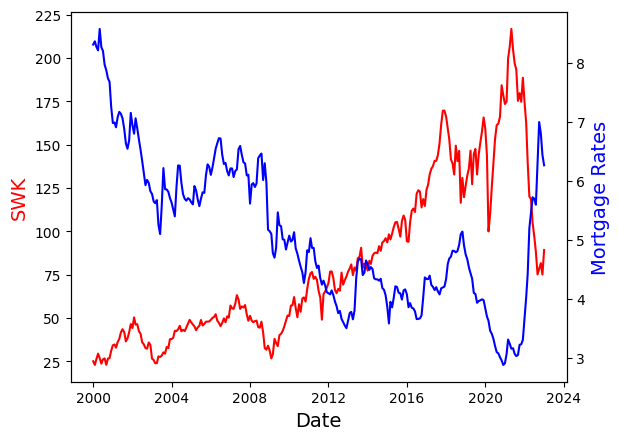

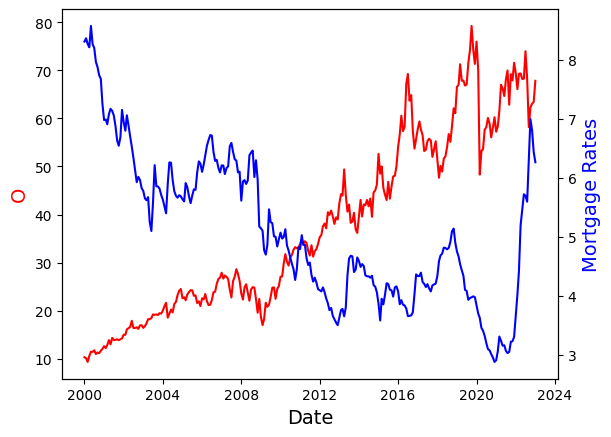

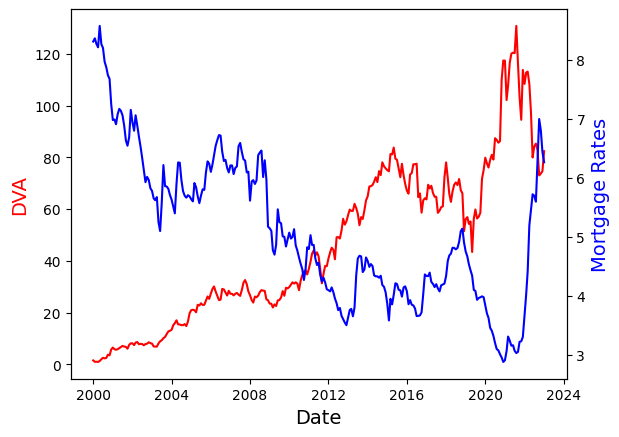

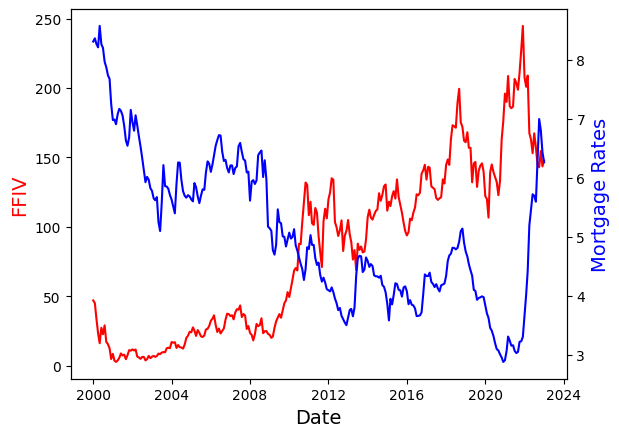

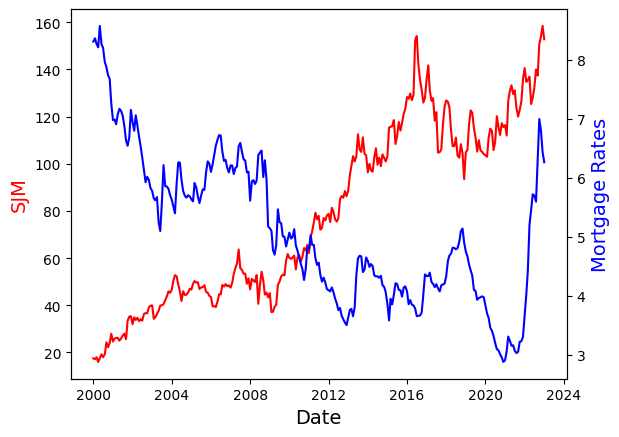

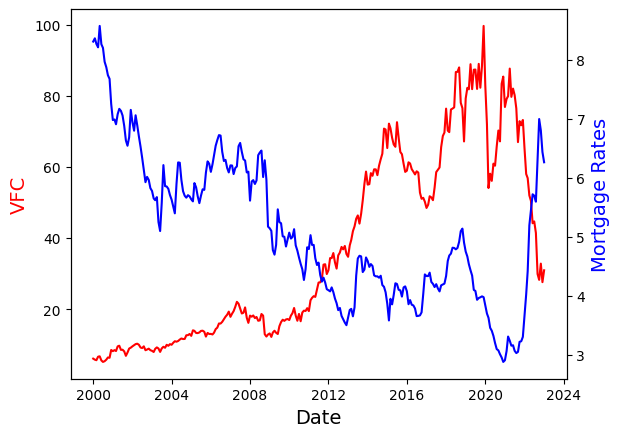

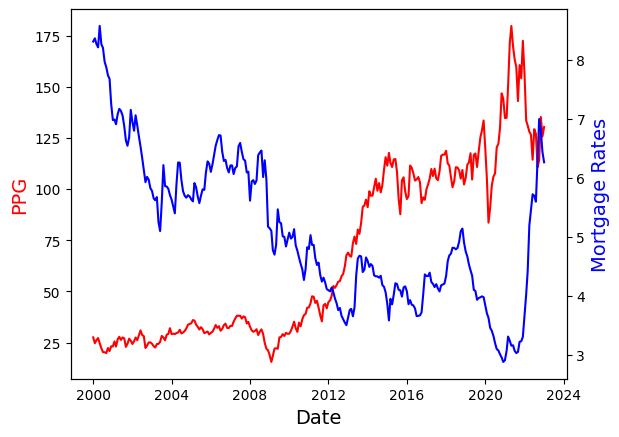

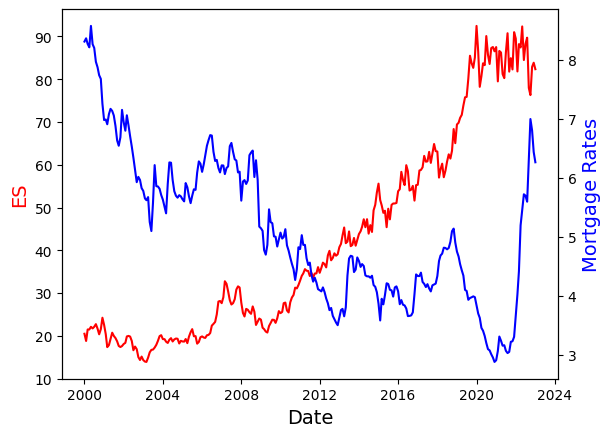

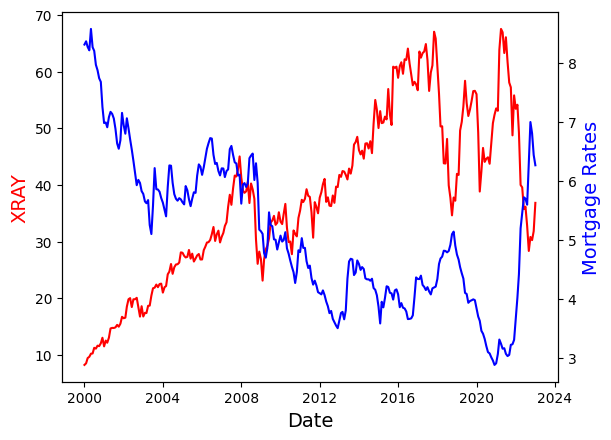

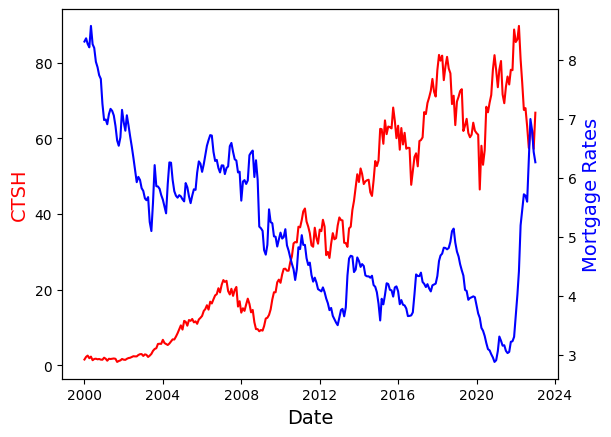

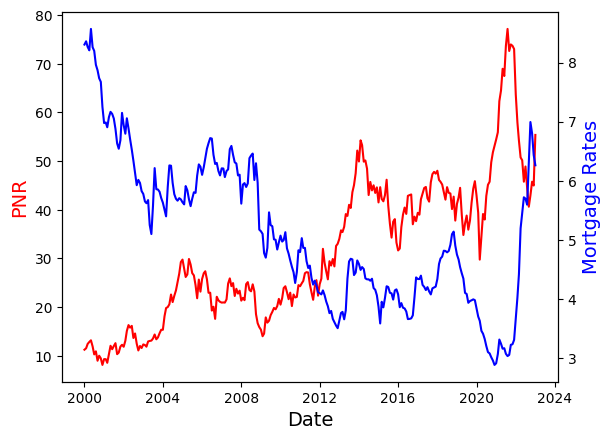

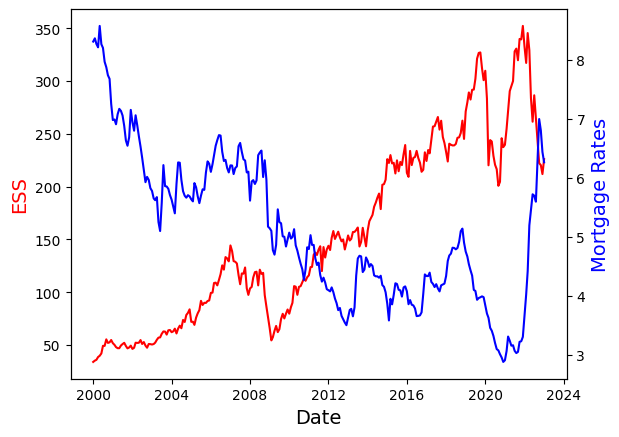

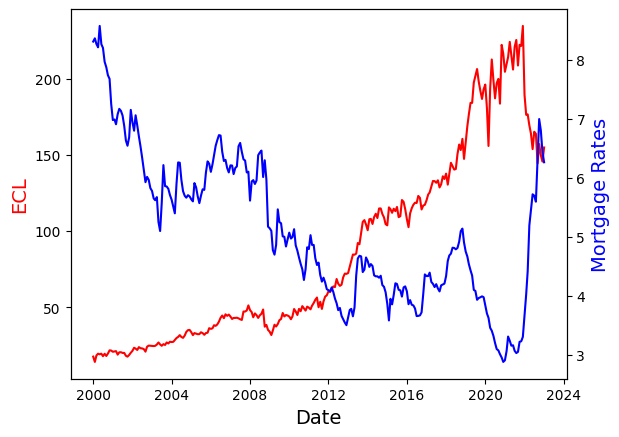

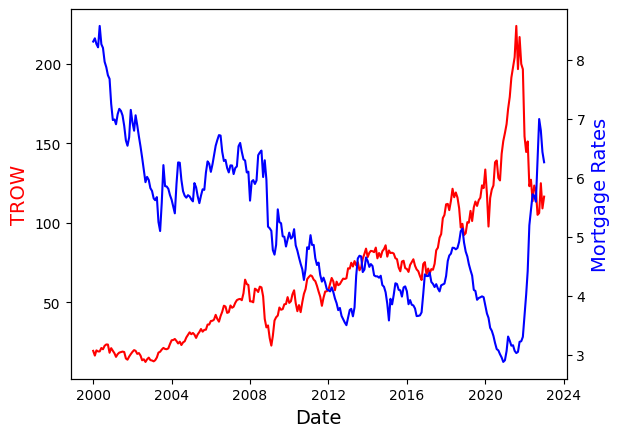

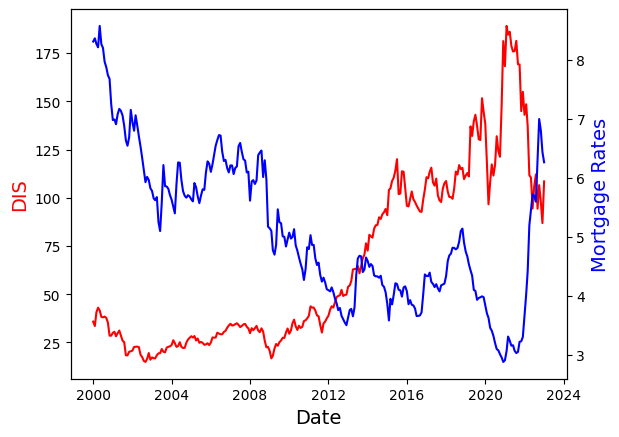

In [27]:
for tkr in graph_df.index:
  graph_series(tkr, mortgage_rates_df.index, targets_df[tkr], mortgage_rates_df['MortgageRates'])

In [30]:
# Load the more detailed price data on stock reactions to Fed price changes that we gathered and backed up earlier.
fed_reactions_df = pd.read_csv('fed-reactions.csv')
fed_reactions_df['date'] = pd.to_datetime(fed_reactions_df['date'])
fed_reactions_df = fed_reactions_df.set_index('date')

In [31]:
fed_price_swings_df = pd.DataFrame()
for dt in tqdm(fed_actions_df.index):
    # Add the action the Fed took to the new dataframe
    fed_price_swings_df.loc[dt, 'fed-rate-change'] = fed_actions_df.loc[dt, 'fed-rate-change']

    # Establish the date seven days before the Fed Fund action and seven days after
    lead_dt = dt - timedelta(days=7)
    trail_dt = dt + timedelta(days=7)

    for ticker in list(fed_reactions_df):
        change_flt = None

        # Get the prices for each equity on that date.
        try:
            lead_price_flt = fed_reactions_df.loc[lead_dt, ticker]
            trail_price_flt = fed_reactions_df.loc[trail_dt, ticker]

            # Calculate the price change
            change_flt = trail_price_flt / lead_price_flt - 1
        except:
            change_flt = None

        # Write the results to the data frame
        fed_price_swings_df.loc[dt, ticker] = change_flt

100%|██████████| 108/108 [00:32<00:00,  3.34it/s]


In [32]:
fed_reactors_df = pd.DataFrame(fed_price_swings_df[fed_price_swings_df['fed-rate-change'] < 0].median(axis=0)).sort_values(0, ascending=False)[:15]

In [44]:
corr_df.loc[['AAON', 'AOS', 'EME', 'EXP', 'HELE', 'JCTCF', 'LII', 'SMBC', 'USLM', 'VMI'], :].sort_values(by='mortgage-rate-corr')

,mortgage-rate-corr
JCTCF,-0.727273
USLM,-0.67614
HELE,-0.660995
AOS,-0.626965
LII,-0.620148
EXP,-0.617687
VMI,-0.590504
AAON,-0.578558
SMBC,-0.5416
EME,-0.533607


In [33]:
fed_reactors_df

,0
BWMN,0.138843
RDN,0.089742
KIRK,0.085916
CRCT,0.084913
JELD,0.080592
REZI,0.074016
MPWR,0.073307
LEN/B,0.072725
HAYW,0.066438
TRMB,0.062163


In [49]:
corr_df.loc['LEN',]

mortgage-rate-corr   -0.386825
Name: LEN, dtype: object

Additional exploration.
1. To overcome the noise it might be best to look at price swings only on the day of and the day following rate change announcements. Of course, mortgage rates are tied more to treasuries than the Fed Funds but... https://en.wikipedia.org/wiki/History_of_Federal_Open_Market_Committee_actions

In [ ]:
targets_df.index[iloc_int - 1]

In [ ]:
trades_df = pd.DataFrame(columns=['Ticker', 'Buy Date', 'Sell Date', 'Open Price', 'Close Price', 'Shares', 'Profit'])
balance_flt = 5000

for idx, current_dt in tqdm(enumerate(targets_df.index[5:])):
    iloc_int = targets_df.index.get_loc(current_dt)
    prior_dt = targets_df.index[iloc_int -1]
    

    for ticker in target_tickers_lst:
        current_open_flt = targets_df.loc[current_dt, ('Open', ticker)]
        prior_close_flt = targets_df.loc[prior_dt, ('Close', ticker)]

        test_tup = zip(list(targets_df[('Close', ticker)][idx-5:idx-1]), list(targets_df[('Close', ticker)][idx-4:idx]))
        test_int = len([b for a,b in test_tup if b<a])

        if ((current_open_flt < (prior_close_flt * 0.95)) ) & (balance_flt > current_open_flt) & (balance_flt > 250):
            if current_open_flt > 250:
                shares_int = 1
            else:
                shares_int = math.floor(250 / current_open_flt)

            position_lst = [ticker, current_dt, None, current_open_flt, None, shares_int, None]
            trades_df.loc[len(trades_df) + 1] = position_lst

            balance_flt = balance_flt - (shares_int * current_open_flt)

    for position in trades_df[trades_df['Sell Date'].isnull()].index:
        ticker_str = trades_df.loc[position, 'Ticker']
        current_price_flt = targets_df.loc[current_dt, ('Open', ticker_str)]
        open_price_flt = trades_df.loc[position, 'Open Price']
        shares_int = trades_df.loc[position, 'Shares']

        if (current_price_flt >= (open_price_flt * 1.15)) or (current_price_flt <= (open_price_flt * 0.90)):
            trades_df.loc[position, 'Sell Date'] = current_dt
            trades_df.loc[position, 'Close Price'] = current_price_flt
            trades_df.loc[position, 'Profit'] = (current_price_flt * shares_int) - (open_price_flt * shares_int)

            balance_flt = balance_flt + (current_price_flt * shares_int)
              

In [ ]:
(trades_df[trades_df['Close Price'].isnull()]['Open Price'] * trades_df[trades_df['Close Price'].isnull()]['Shares']).sum() 

In [ ]:
trades_df['Profit'].cumsum().plot()

In [ ]:
balance_flt